In [1]:
import cv2

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import os
import sys
sys.path.append(os.path.abspath('../'))

import torch
import numpy as np

from plates.transforms import Compose, ToTensor, Resize

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from plates.models import PlatesDetector

In [ ]:
model = PlatesDetector.load_from_checkpoint('../checkpoints/detector_epoch=01-val_dice=0.87.ckpt').to(device)
model.eval()

In [ ]:
from plates.datasets import DetectionDataset

In [ ]:
transforms = Compose([
    ToTensor()
])

#dataset = DetectionDataset('/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/', None, transforms=transforms)
dataset = DetectionDataset('/home/kovalexal/Spaces/dev/car_plates_ocr/data/', '/home/kovalexal/Spaces/dev/car_plates_ocr/data/train.json', transforms=transforms)

In [ ]:
def visualize_prediction(image):
    cv2_image = image.permute(1, 2, 0).cpu().numpy()
    
    image = image.to(device)
    
    with torch.no_grad():
        output = model([image])[0]
    
    for i in range(len(output['scores'])):
        # Пропускаем все кроме номера
        if output['labels'][i] != 1:
            continue
        
        # Берем bbox и score
        box = output['boxes'][i].detach().cpu().numpy()
        width, height = box[2] - box[0], box[3] - box[1]
        score = output['scores'][i].detach().cpu().numpy()
        
        # Рисуем bbox
        cv2.rectangle(cv2_image, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
        # Отмечаем score
#         print(box)
        cv2.putText(cv2_image, '{:2f}'.format(score), (int(box[0]), int(box[1] - 10)), 0, 1, (1, 0, 0), 2)
        
#     print(output)
    plt.figure(figsize=(12, 7))
    plt.imshow(cv2_image)

visualize_prediction(dataset[0][0])

In [ ]:
import random

In [ ]:
import random

In [ ]:
for i in random.sample(range(len(dataset)), 5):
    visualize_prediction(dataset[1339][0])

In [ ]:
import torch.nn as nn

In [ ]:
from torchvision import models

In [ ]:
resnet18 = models.resnet18(pretrained=True)

In [ ]:
resnet50 = models.resnet50(pretrained=True)

In [ ]:
resnet50

In [ ]:
cnn = nn.Sequential(*list(resnet50.children())[:-2])

In [ ]:
cnn

In [ ]:
dataset

In [ ]:
models.resne

In [ ]:
resnext50 = models.resnext50_32x4d(pretrained=True)

In [ ]:
resnext50

In [ ]:
cnn = nn.Sequential(*list(resnext50.children())[:-2])
cnn_input = dataset[0][0].unsqueeze(0)
print(cnn_input.shape)
cnn_output = cnn(cnn_input)
print(cnn_output.shape)

In [ ]:
pool = nn.AvgPool2d(kernel_size=(1396//32, 1))
pool_in = cnn_output
print(pool_in.shape)
pool_out = pool(pool_in)
print(pool_out.shape)

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_size=(520, 115), backbone='resnet18', output_len=20):
        super().__init__()

        w, h = input_size
        resnet = getattr(models, backbone)(pretrained=True)

        self.cnn = nn.Sequential(*list(resnet.children())[:-2])
        self.pool = nn.AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = nn.Conv2d(w // 32, output_len, kernel_size=1)

        self.num_output_features = self.cnn[-1][-1].bn2.num_features

    def apply_projection(self, x):
        """Use convolution to increase width of a features.
        Accepts tensor of features (shaped B x C x H x W).
        Returns new tensor of features (shaped B x C x H x W')
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        return x

    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)

        # Pool to make height == 1
        features = self.pool(features)

        # Apply projection to increase width
        features = self.apply_projection(features)

        return features

In [ ]:
fe = FeatureExtractor().eval()

In [ ]:
from torchvision.transforms import Resize

In [ ]:
fe(dataset[0][0].unsqueeze(0))

In [ ]:
nn.Conv2d?

In [ ]:
cnn.eval()

In [ ]:
nn.Conv2d?

In [ ]:
from torchvision.transforms import Resize

In [ ]:
Resize?

In [ ]:
cv2.bitwise_and?

In [ ]:
cv2.copyTo?

In [ ]:
cv2.findContours?

In [ ]:
import torch.nn as nn

In [ ]:
import pytorch_lightning as pl

In [ ]:
model.device

In [ ]:
class PlatesClipper(nn.Module):
    def __init__(self, detection_model, score_threshold=0.95, mask_threshold=0.05):
        super().__init__()
        
        # Сохраняем модель детекции
        self.detection_model = detection_model
        self.detection_model.eval()
        
        # Запомним device модели
        self.device = self.detection_model.device
        
        # Сохраняем пороги отсечения (для класса bbox'а и для маски)
        self.score_threshold = score_threshold
        self.mask_threshold = mask_threshold
        
    def forward(self, images):
        # Прогоняем картинки через модель
        with torch.no_grad():
            outputs = self.detection_model(images)
            
        

In [ ]:
from tqdm import tqdm

In [ ]:
def order_points(pts):
    # https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


def four_point_transform(image, pts):
    # https://www.pyimagesearch.com/2014/08/25/4-point-opencv-getperspective-transform-example/

    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

In [ ]:
def get_plate_box(image, score_threshold=0.95, mask_threshold=0.05):
    cv2_image = image.permute(1, 2, 0).cpu().numpy()
    
    image = image.to(device)
    
    with torch.no_grad():
        output = model([image])[0]
        
    for i in range(len(output['scores'])):
        # Пропускаем все кроме номера
        if output['labels'][i] != 1:
            continue
            
        # Пропускаем все номера по порогу
        if output['scores'][i] < score_threshold:
            continue
        
        # Накладываем маску
        mask = output['masks'][i].detach().cpu().numpy()
        mask = (mask[0] > mask_threshold).astype(np.uint8)
        background = np.zeros(cv2_image.shape, np.float32)
        background[:] = (1., 0., 0.)
#         cv2.copyTo(background, mask=mask, dst=cv2_image)
        
        # Находим минимальный обрамляющий прямоугольник
        contour = cv2.findContours(mask.copy(), 1, 1)[0][0]
        rect = cv2.minAreaRect(contour)
        (x,y),(w,h), a = rect
        box = cv2.boxPoints(rect)
        print(box)
        
        
        image_plate = four_point_transform(cv2_image, box)
        plt.imshow(image_plate)
        plt.show()
        
#         cv2.fillConvexPoly(cv2_image, box.astype(np.int32), (0., 1., 0.), 4)
        
#         cv2.rectangle(cv2_image, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
        
        
        
    plt.figure(figsize=(12, 7))
    plt.imshow(cv2_image)

get_plate_box(dataset[1339][0])

In [ ]:
cv2.fillConvexPoly?

In [ ]:
cv2.boxPoints?

In [ ]:
cv2.minAreaRect?

In [ ]:
from plates.datasets import ExtractedRecognitionDataset, GeneratedRecognitionDataset

In [ ]:
from torchvision.transforms import Compose, ToTensor

In [ ]:
from plates.transforms import Resize

In [ ]:
transforms = Compose([
    Resize((520, 115)),
    ToTensor()
])

generated_dataset = GeneratedRecognitionDataset(
    '/home/kovalexal/Spaces/dev/car_plates_ocr/data/generated_60k/',
    transforms=transforms
)

extracted_dataset = ExtractedRecognitionDataset(
    '/home/kovalexal/Spaces/dev/car_plates_ocr/data/train/',
    transforms=transforms
)

In [ ]:
from torch.utils.data import ConcatDataset

In [ ]:
dataset = ConcatDataset([generated_dataset, extracted_dataset])

In [ ]:
len(extracted_dataset)

In [ ]:
len(generated_dataset)

In [ ]:
59987 + 26239

In [ ]:
len(dataset)

In [ ]:
import torch.functional as F

In [ ]:
import torch.nn.functional as F

In [ ]:
F.ctc_loss

In [24]:
from plates.models import PlatesRecognition

In [25]:
recognition_model = PlatesRecognition.load_from_checkpoint('../checkpoints/recongnition_epoch=07-val_loss=0.0879.ckpt').to(device)
recognition_model.eval()

PlatesRecognition(
  (crnn): CRNN(
    (features_extractor): FeatureExtractor(
      (cnn): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [6]:
from plates.datasets import ExtractedRecognitionDataset

In [7]:
from plates.models.recognition import abc, decode, pred_to_string

In [20]:
from plates.transforms import Resize
from torchvision.transforms import Compose

In [21]:
transforms = Compose([
    Resize((520, 115)),
    # ToTensor(),
])

extracted_model_dataset = ExtractedRecognitionDataset(
    '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/',
    mask='*.ebox.*',
    transforms=transforms
)


# def plot_decode(i):
#     image = extracted_model_dataset[i]['image']
    
#     plt.imshow(image)
#     plt.show()

#     torch_image = torch.from_numpy(image.transpose((2, 0, 1))).float().to(device)
#     print(decode(recognition_model(torch_image.unsqueeze(0)), abc))

In [62]:
from tqdm import tqdm

In [83]:
info = []

for i in tqdm(range(len(extracted_model_dataset)), total=len(extracted_model_dataset)):
    filepath = extracted_model_dataset.images[i]
    image = extracted_model_dataset[i]['image']
    
    split = filepath.split('/')
    folder, file = split[-2], split[-1]
    filesplit = file.split('.')
    file = '.'.join([filesplit[0], filesplit[-1]])
    path = os.path.join(folder, file)
    
    torch_image = torch.from_numpy(image.transpose((2, 0, 1))).float().to(device)
    decoded = decode(recognition_model(torch_image.unsqueeze(0)), abc)
    
    info.append((path, decoded[0]))
    
#     break

100%|██████████| 3515/3515 [00:47<00:00, 74.35it/s]


In [84]:
import pandas as pd

In [85]:
info = pd.DataFrame.from_records(info, columns=['file_name', 'plates_string'])

In [86]:
info.head()

,file_name,plates_string
0,test/1444.bmp,Y798AC35
1,test/1643.jpg,B222YK177
2,test/1453.bmp,A190PK35
3,test/472.jpg,E775KM197
4,test/2930.jpg,K373HE16


In [87]:
submission_info = []

for file_name, file_df in info.groupby(['file_name']):
    plates_string = ' '.join(sorted(file_df['plates_string']))
    submission_info.append((file_name, plates_string))

In [88]:
submission_info = pd.DataFrame.from_records(submission_info, columns=['file_name', 'plates_string'])

In [92]:
submission_info.to_csv('submission_02.csv', index=False)

In [93]:
submission_info.head()

,file_name,plates_string
0,test/0.jpg,O195KC96
1,test/1.jpg,O001OO24 O005OO21
2,test/10.jpg,T477PY197
3,test/100.jpg,P152HT54
4,test/1000.jpg,B979KM163


In [99]:
import re

In [107]:
submission_info['num'] = submission_info['file_name'].apply(lambda x: int(re.search(r'\d+', x).group(0)))

In [114]:
has = set(sorted(submission_info['num'].values.tolist()))
need = set(list(range(3188)))

In [115]:
need.difference(has)

{721, 791, 1015, 1087, 1143, 1337, 1500, 1524, 1664, 2237, 2249, 2303, 2972}

In [108]:
submission_info.sort_values(by='num').drop(columns=['num']).to_csv('submission_02.csv', index=False)

In [49]:
extracted_model_dataset.images

['/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/1444.ebox.0.bmp',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/1643.ebox.0.jpg',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/1453.ebox.0.bmp',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/472.ebox.0.jpg',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/2930.ebox.1.jpg',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/1787.ebox.0.jpg',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/1952.ebox.0.jpg',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/3154.ebox.0.jpg',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/2140.ebox.0.bmp',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/2970.ebox.0.bmp',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/3130.ebox.0.bmp',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/504.ebox.0.bmp',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/935.ebox.0.jpg',
 '/home/kovalexal/Spaces/dev/car_plates_ocr/data/test/595.ebox.0.jp

In [22]:
len(extracted_model_dataset)

3515

In [23]:
extracted_model_dataset[0]

{'image': array([[[0.15556276, 0.17894822, 0.13978049],
         [0.15609337, 0.17967221, 0.14044003],
         [0.15632585, 0.1812725 , 0.14158441],
         ...,
         [0.24859777, 0.23071933, 0.20675758],
         [0.24605303, 0.2281746 , 0.20421284],
         [0.2445519 , 0.22667345, 0.2027117 ]],
 
        [[0.15698528, 0.18071003, 0.14148217],
         [0.15752476, 0.18111436, 0.14193156],
         [0.15788095, 0.18185394, 0.14254335],
         ...,
         [0.25129563, 0.23045446, 0.20722012],
         [0.24832897, 0.2274878 , 0.20425348],
         [0.24662276, 0.22578157, 0.20254727]],
 
        [[0.15916446, 0.18457218, 0.1454657 ],
         [0.15980218, 0.18424198, 0.14545813],
         [0.16062772, 0.18300985, 0.14491189],
         ...,
         [0.25680965, 0.23009396, 0.20815767],
         [0.2529863 , 0.22627062, 0.20433432],
         [0.25087318, 0.22415748, 0.20222123]],
 
        ...,
 
        [[0.35375673, 0.33807045, 0.39726165],
         [0.35197186, 0.33628562

In [46]:
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


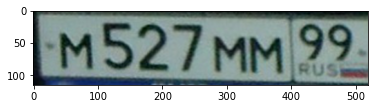

['M527MM99']


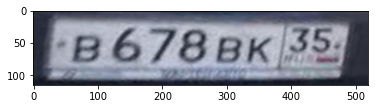

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['B678BK35']


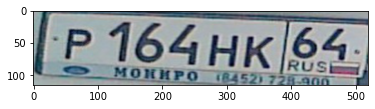

['P164HK64']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


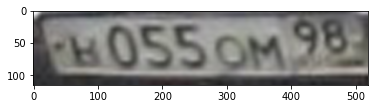

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['H055OM98']


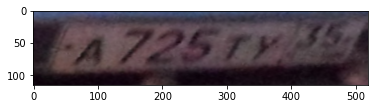

['A725TY35']


In [48]:
def plot_decode(i):
    image = extracted_model_dataset[i]['image']
    
    plt.imshow(image)
    plt.show()

    torch_image = torch.from_numpy(image.transpose((2, 0, 1))).float().to(device)
    print(decode(recognition_model(torch_image.unsqueeze(0)), abc))
    
# for i in range(10):
#     plot_decode(i)
    
for i in random.sample(range(len(extracted_model_dataset)), 5):
    plot_decode(i)

In [27]:
recognition_model(extracted_model_dataset[0]['image'])

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not numpy.ndarray